# Лабораторная работа №1: Поэлементные преобразования изображений

*Вариант 1*

Выполнил:

студент группы 6132-010402D

Баканов Дмитрий

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict, Optional

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


IMAGE_PATH = "./images/Lenna.png"


def plot_image(input_image: np.ndarray) -> None:
    """Функция отрисовки изображения."""
    %matplotlib inline
    image_shape = input_image.shape
    plt.axis("off")
    if len(image_shape) == 3:
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(input_image, cmap='gray')

def plot_hist(
        grayscale_image: np.ndarray,
        plot_title: Optional[str] = None,
        nbr_bins: int = 256,
        plot_cdf: bool = False,
) -> None:
    """Функция отрисовки гистограммы изображения."""
    plt.figure(figsize=(10, 5))
    plt.xlim([-10, 260])
    if plot_title:
        plt.title(plot_title)

    if not plot_cdf:
        plt.hist(grayscale_image.flatten(), bins=nbr_bins, density=True)
    else:
        image_hist, bins = np.histogram(grayscale_image.flatten(), nbr_bins, [0, 255])
        cdf = image_hist.cumsum()
        norm_cdf = cdf * float(image_hist.max()) / cdf.max()
        plt.plot(norm_cdf, color='b')
        plt.hist(grayscale_image.flatten(), nbr_bins, [0, 255], color='r')
        plt.legend(("функция распределения", "гистограмма"), loc="upper left")
    plt.grid(True)
    plt.show()

*Задание 1. Считать цветное rgb изображение.*

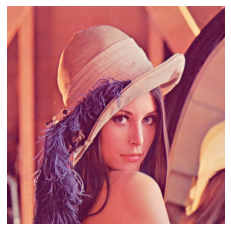

In [2]:
image = cv2.imread(IMAGE_PATH)
plot_image(image)

In [3]:
image.shape

(512, 512, 3)

*Задание 2. Преобразовать изображение в градации серого*

Для преобразования изображения в оттенки серого можно воспользоваться формулой:

$$ Y = 0.2126 * R + 0.7152 * G + 0.0722 *  B $$

In [4]:
def get_grayscale_image(rgb_image: np.ndarray) -> np.ndarray:
    grayscale_image = np.dot(rgb_image[..., :3], np.array([0.2126, 0.7152, 0.0722]))
    return grayscale_image.astype(np.uint8)

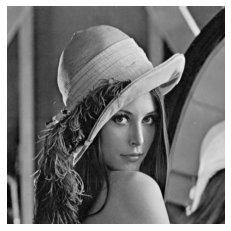

In [5]:
gray_image = get_grayscale_image(image)
plot_image(gray_image)

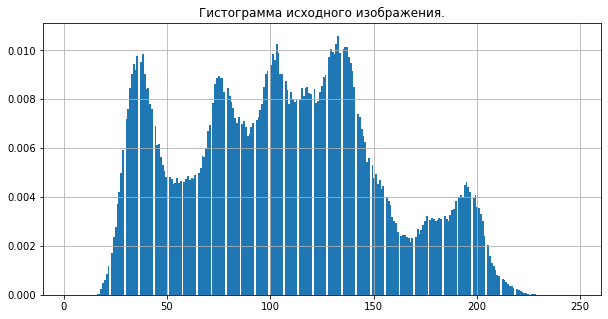

In [6]:
plot_hist(gray_image, plot_title="Гистограмма исходного изображения.")

*Задание 3. Написать функцию реализации препарирования изображения*

В данном варианте функция препарирования представляет собой ступенчатую функцию вида:

\begin{equation*}
y(x) =
 \begin{cases}
   a &\text{ if b < x < c}\\
   0 &\text{ else}
 \end{cases}
\end{equation*}

$$a,\:b\:and\:с - const$$

Представляет *яркостной срез*.

In [7]:
def image_preparation(grayscale_image: np.ndarray, func) -> np.ndarray:
    new_image = np.vectorize(func)(grayscale_image)
    return new_image.astype(np.uint8)

In [8]:
def prep_func(x, a: int = 255, b: int = 85, c: int = 167) -> int:
    """Функция препарирования.
    a - значение интенсивности при попадании яркости в интервал,
    b - левая граница интервала,
    с - правая граница инервала
    """
    if b < x < c:
        return a
    else:
        return 0

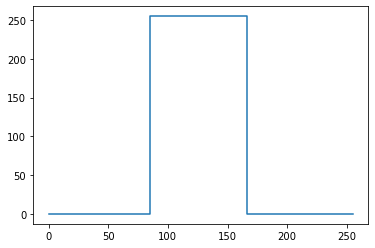

In [9]:
x_list = range(0, 256)
y_list = [prep_func(x) for x in x_list]
plt.step(x_list, y_list)

*Задание 4. По гистограмме изображения определить значение порога яркостей, обеспечивающего оптимальное разделение объекта и фона. Осуществить пороговую обработку входного изображения с найденным пороговым значением:*

* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*
* *Порог определить на глаз по гистограмме*


Пороговая обработка осуществлялась согласно следующей формуле:
\begin{equation*}
y(x) =
 \begin{cases}
   255 &\text{ if x > threshold}\\
   0 &\text{ else}
 \end{cases}
\end{equation*}

$$ threshold - const $$

In [10]:
def get_threshold_image(grayscale_image: np.ndarray, threshold: int) -> np.ndarray:
    """Функция, выполняющая пороговую обработку."""
    return np.vectorize(lambda x: 255 if x > threshold else 0)(grayscale_image)

Исходное изображение.


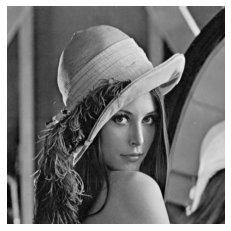

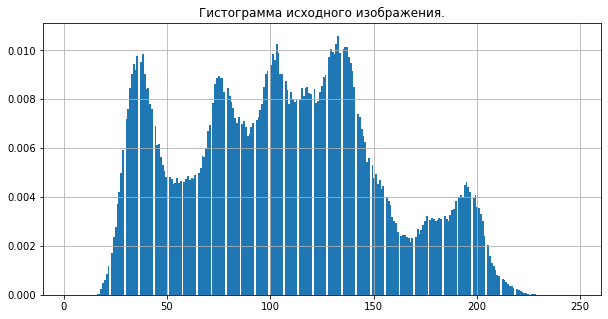

In [11]:
print("Исходное изображение.")
plot_image(gray_image)
plot_hist(gray_image, plot_title="Гистограмма исходного изображения.")

In [12]:
threshold_image = get_threshold_image(gray_image, threshold=120)

Пороговая обработка изображения.


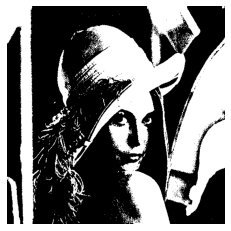

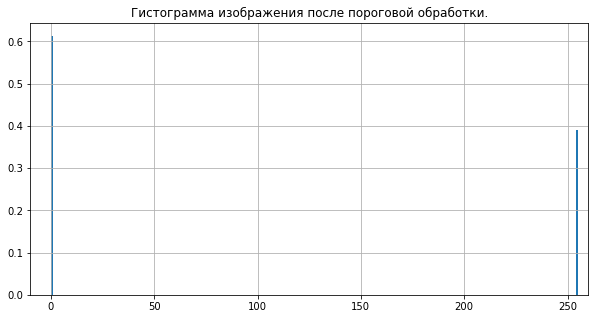

In [13]:
print("Пороговая обработка изображения.")
plot_image(threshold_image)
plot_hist(threshold_image, plot_title="Гистограмма изображения после пороговой обработки.")

*Задание 5. Сделать пороговую обработку методом `Otsu` (Функция OpenCV)*
* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*


Метод `Otsu` основан на минимизации внутриклассовой дисперсии:

$$ \sigma_{w}^2 (t) = w_0 (t) \sigma_0^2 (t) + w_1 (t) \sigma_1^2 (t) \rightarrow min ,$$

*где* $t$ - *пороговое значение*, $ w_0 (t) $ *и* $ w_1 (t) $ - *это сумма вероятностей внутри классов, разделенных пороговым значением* $ t $, $ \sigma_0^2 (t) $ *и* $ \sigma_1^2 (t) $ - *внутриклассовые дисперсии*

Исходное изображение.


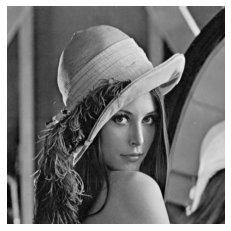

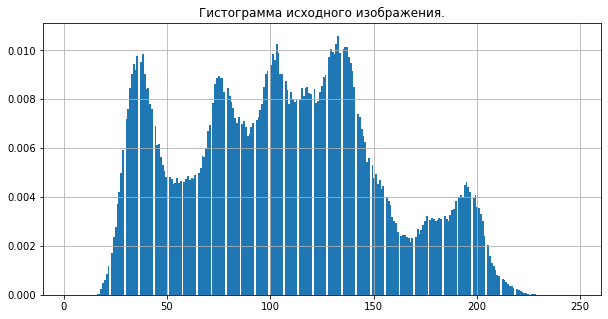

In [14]:
print("Исходное изображение.")
plot_image(gray_image)
plot_hist(gray_image, plot_title="Гистограмма исходного изображения.")

In [15]:
opencv_threshold, opencv_threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)

Пороговая обработка методом Otsu изображения.


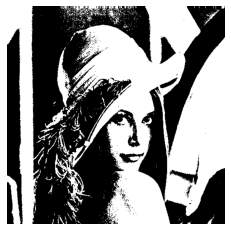

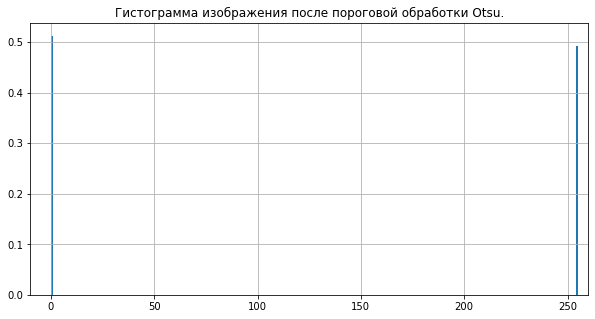

In [16]:
print("Пороговая обработка методом Otsu изображения.")
plot_image(opencv_threshold_image)
plot_hist(opencv_threshold_image, plot_title="Гистограмма изображения после пороговой обработки Otsu.")

*Задание 6. Определить динамический диапазон входного изображения. Осуществить линейное контрастирование входного изображения в заданный динамический диапазон яркостей*
* *__Вход:__ изображение у которого диапазон не на всем промежутке [0,255]*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*
* *Вычислить коэффициенты $ a $ и $ b $. Сделать преобразование вида:* $ g =a * f + b $

Надо получить преобразование вида:

$$ [x_{min}, x_{max}] → [y_{min}, y_{max}] $$

Используя преобразование:

$$ y = a x + b $$

Составим систему:

\begin{equation*}
 \begin{cases}
   y_{min} = a x_{min} + b
   \\
   y_{max} = a x_{max} + b
 \end{cases}
\end{equation*}

Откуда получаем:

$$ a = \frac{y_{max} - y_{min}}{x_{max} - x_{min}}$$
$$ b = \frac{y_{min} x_{max} - y_{max} x_{min}}{x_{max} - x_{min}} $$

В нашем случае:

$ x_{max}, x_{min} $ - *минимальная и максимальная яркости изображений*, $ y_{max} = 255,  y_{min} = 0$

In [17]:
def linear_contrast(grayscale_image: np.ndarray) -> Dict[str, Any]:
    """Функция для проведения линейного контрастирования."""
    results = dict()

    x_min = grayscale_image.flatten().min()
    x_max = grayscale_image.flatten().max()

    y_min = 0
    y_max = 255
    a = (y_max - y_min) / (x_max - x_min)
    b = (y_min * x_max - y_max * x_min) / (x_max - x_min)

    result_image = np.vectorize(lambda x: a * x + b)(grayscale_image)
    result_image = result_image.astype(np.uint8)

    results["original_range"] = (x_min, x_max)
    results["original_image"] = grayscale_image.copy()
    results["a"] = a
    results["b"] = b
    results["result_range"] = (result_image.flatten().min(), result_image.flatten().max())
    results["result_image"] = result_image.copy()

    return results

In [18]:
gray_man = get_grayscale_image(cv2.imread("./images/man.png"))

In [19]:
linear_contrast_results = linear_contrast(gray_man)

In [20]:
print(f"Линейное преобразование для данного изображения: y = {linear_contrast_results['a']} * x + {linear_contrast_results['b']}.")

Линейное преобразование для данного изображения: y = 2.802197802197802 * x + -260.6043956043956.


Динамический диапазон исходного изображения: (93, 184).


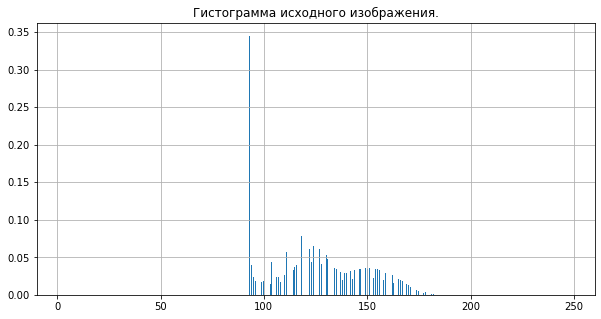

In [21]:
print(f"Динамический диапазон исходного изображения: {linear_contrast_results['original_range']}.")
plot_hist(linear_contrast_results['original_image'], plot_title="Гистограмма исходного изображения.")

Динамический диапазон после линейного контрастирования: (0, 254).


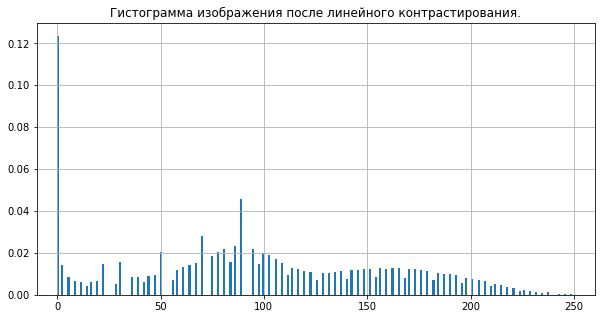

In [22]:
print(f"Динамический диапазон после линейного контрастирования: {linear_contrast_results['result_range']}.")
plot_hist(linear_contrast_results['result_image'], plot_title="Гистограмма изображения после линейного контрастирования.")

Исходное изображение.


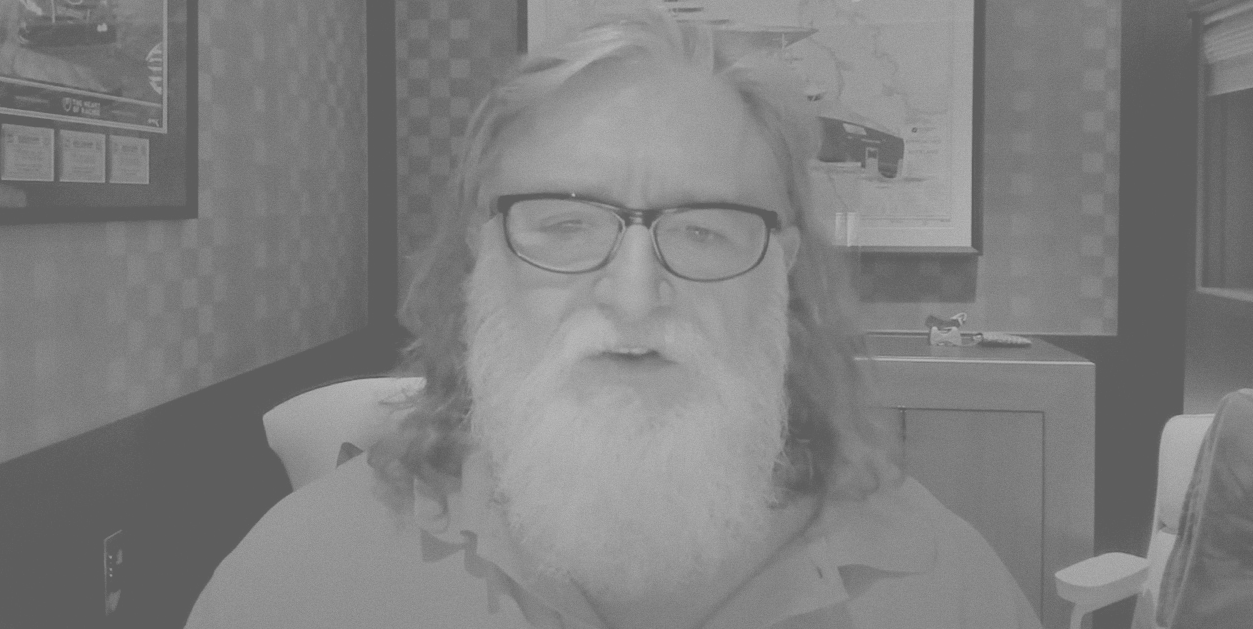

In [23]:
from PIL import Image
print("Исходное изображение.")
Image.fromarray(linear_contrast_results['original_image'])

Изображение после линейного контрастирования.


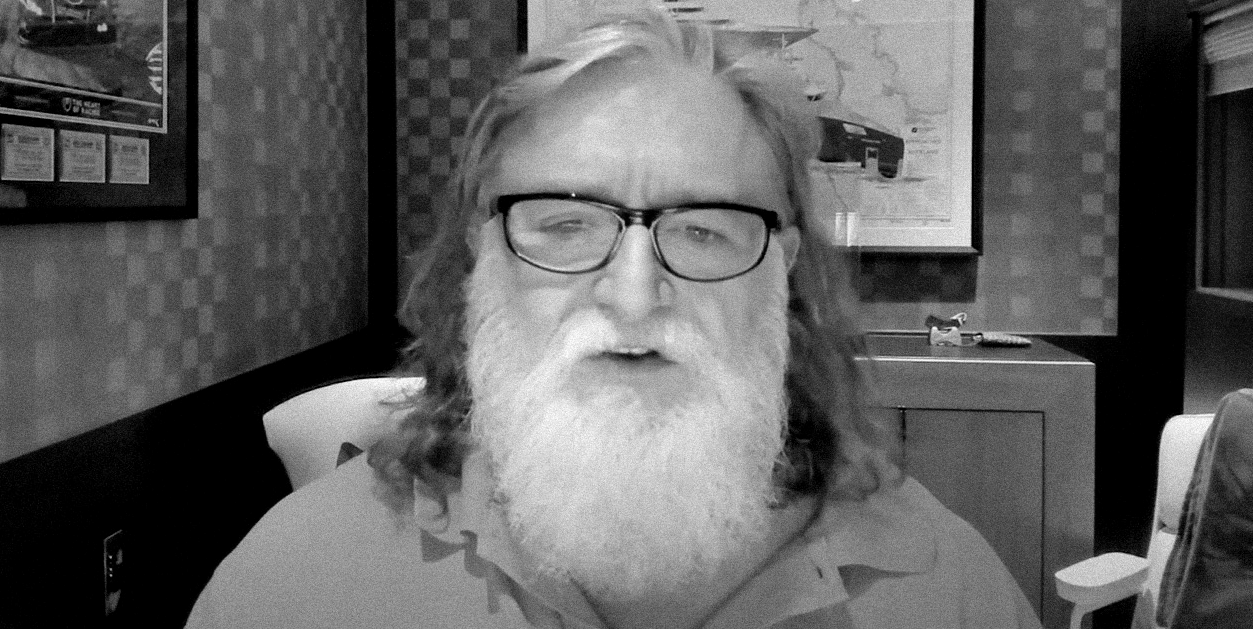

In [24]:
print("Изображение после линейного контрастирования.")
Image.fromarray(linear_contrast_results['result_image'])

*Задание 7. Сделать эквализацию гистограммы изображения*
* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*

Эквализацию гистограммы можно провести с помощью следующего приема:

$$ h (x) =  round \left( \frac{cdf(x) - cdf_{min}}{(M * N) - 1} * (L - 1) \right) ,$$

*где* $ cdf(x) $ - *функция распределения (коммулятивная функция),*  $ cdf_{min} $ - *наименьшее ненулевое значение функции распределение,* $ M * N $ - *размер изображения*, $ L $ - *количество уровней серого*

In [25]:
def image_equalization(grayscale_image: np.ndarray) -> np.ndarray:
    """Функция проведения эквализации гистограммы изображения."""
    n, m = grayscale_image.shape

    image_hist, bins = np.histogram(grayscale_image.flatten(), 256, [0, 256])
    cdf = image_hist.cumsum()

    result_cdf = (cdf - cdf[0]) * 255 / (n * m - 1)

    result_cdf = result_cdf.astype(np.uint8)
    result_image = result_cdf[grayscale_image]
    return result_image

Исходное изображение.


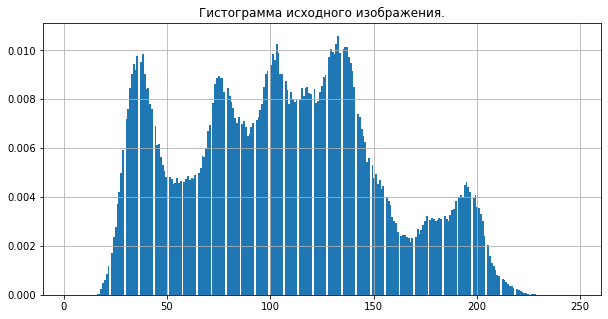

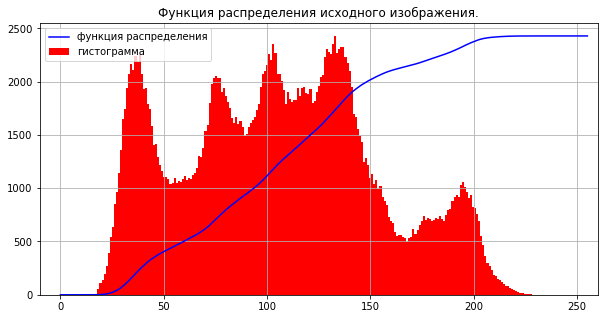

In [26]:
print("Исходное изображение.")
plot_hist(gray_image, plot_title="Гистограмма исходного изображения.")
plot_hist(gray_image, plot_title="Функция распределения исходного изображения.", plot_cdf=True)

Эквализированное изображение.


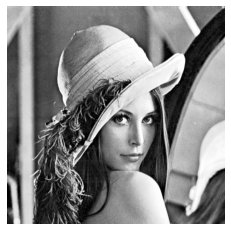

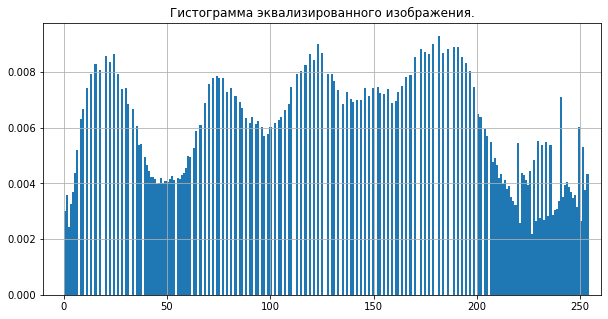

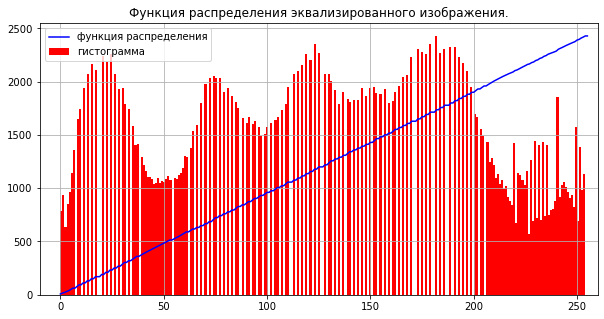

In [27]:
image_equal = image_equalization(gray_image)
print("Эквализированное изображение.")
plot_image(image_equal)
plot_hist(image_equal, plot_title="Гистограмма эквализированного изображения.")
plot_hist(image_equal, plot_title="Функция распределения эквализированного изображения.", plot_cdf=True)

*Задание 8. Сделать эквализацию методом `CLAHE` (Функция OpenCV)*
* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*

In [28]:
opencv_image_equal = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(gray_image)

Исходное изображение.


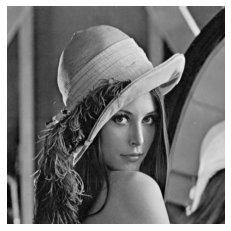

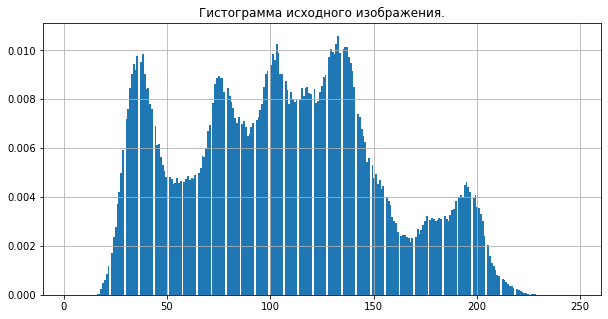

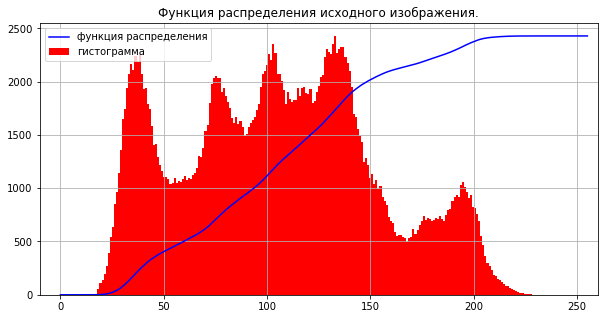

In [29]:
print("Исходное изображение.")
plot_image(gray_image)
plot_hist(gray_image, plot_title="Гистограмма исходного изображения.")
plot_hist(gray_image, plot_title="Функция распределения исходного изображения.", plot_cdf=True)

Эквализированное изображение по CLAHE.


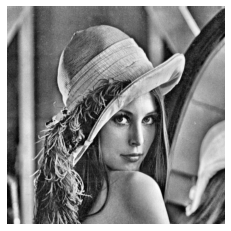

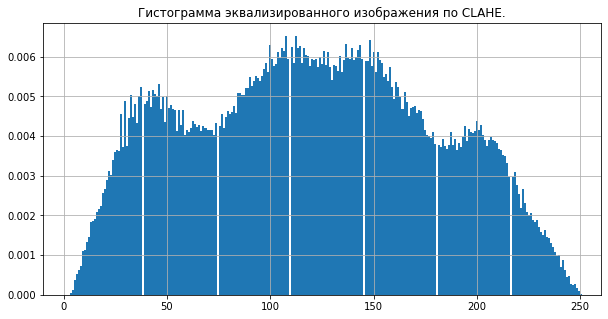

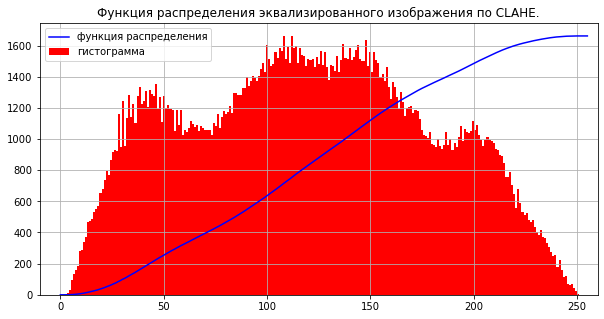

In [30]:
print("Эквализированное изображение по CLAHE.")
plot_image(opencv_image_equal)
plot_hist(opencv_image_equal, plot_title="Гистограмма эквализированного изображения по CLAHE.")
plot_hist(opencv_image_equal, plot_title="Функция распределения эквализированного изображения по CLAHE.", plot_cdf=True)

*Задание 9. Осуществить препарирование изображения с заданной препарирующей функцией*
* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно. График препарирующий функции.*
* Пороги в препарирующей функции выбирать самостоятельно

In [31]:
prep_image = image_preparation(gray_image, prep_func)

Исходное изображение.


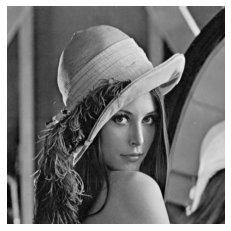

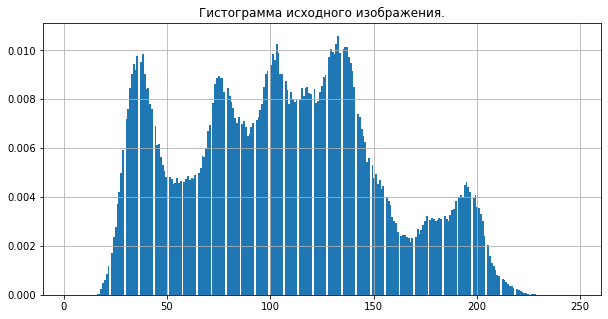

In [32]:
print("Исходное изображение.")
plot_image(gray_image)
plot_hist(gray_image, plot_title="Гистограмма исходного изображения.")

Препарированное изображение.


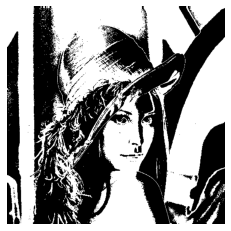

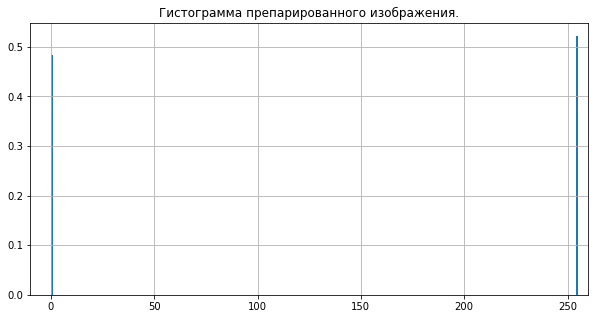

In [33]:
print("Препарированное изображение.")
plot_image(prep_image)
plot_hist(prep_image, plot_title="Гистограмма препарированного изображения.")